In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import os
import imageio
import requests
from ipywidgets import Image
import ipywidgets

import datajoint as dj

In [2]:
dj.__version__

'0.12.0'

In [3]:
schema = dj.schema('common_attach')

Connecting dimitri@ucsd-demo-db.datajoint.io:3306


## Download UCSD logo into a local file

In [4]:
uri = "https://ucsd.edu/_resources/img/logo_UCSD.png"
Image.from_url(uri)

Image(value=b'https://ucsd.edu/_resources/img/logo_UCSD.png', format='url')

In [5]:
# save image as local_file
pngdata = requests.get(uri).content
name = uri.split('/')[-1]
local_file = os.path.join(os.path.abspath('.'), name)
with open(local_file, 'wb') as f:
    f.write(pngdata)
Image.from_file(local_file)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xfe\x00\x00\x00f\x08\x06\x00\x00\x00*-\xf3\xbf\x…

## Store images as attachments or blobs in DataJoint

In [6]:
## Storage configuration

# load S3 credentials
import json
with open('s3-creds.json') as f:
    s3_creds = json.load(f)
 
# set up stores
dj.config['stores'] = {
    
    '-': {    # store inside the tables
       'protocol': 'longblob' 
    },
    
    '-shared': {    #  store in s3
        'protocol' : 's3',
        'endpoint' : 's3.amazonaws.com',
        'bucket' : 'mousebrainatlas-datajoint',
        'location' : 'dj-store',
        **s3_creds
    },
    
    '-local': {  # store in files
        'protocol' : 'file',
        'location' : os.path.abspath('./dj-store')
    }
}

In [7]:
# Declare a table with configurable blobs and attachments
@schema
class Slide(dj.Manual):
    definition = """
    slide : int
    ---
    img_file : attach-shared  # attachment in specified store
    img_array : blob-local  # array in specified store
    """

In [8]:
Slide.insert1(dict(
    slide=1, img_file=local_file, img_array=imageio.imread(local_file)))

## Retrieve attachments and arrays from configurable stores

In [9]:
# preview 
Slide()

slide,img_file attachment in specified store,img_array array in specified store
1,=BLOB=,=BLOB=


In [10]:
# fetch data 
f, a = (Slide & 'slide=1').fetch1('img_file', 'img_array')

In [11]:
print(f)
Image.from_file(f)

/Users/dimitri/vathes/ucsd/Datajoint_Interface/demo/logo_UCSD_000e.png


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xfe\x00\x00\x00f\x08\x06\x00\x00\x00*-\xf3\xbf\x…

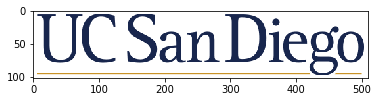

In [12]:
plt.imshow(a)

In [13]:
Slide.delete()

About to delete:
`common_attach`.`slide`: 1 items
Proceed? [yes, No]: yes
Committed.
